# Introduction to Seq2Seq and LSTM for Machine Translation

To build a machine translation model using a sequence-to-sequence (seq2seq) architecture with LSTM (Long Short-Term Memory) networks, it is crucial to understand the fundamentals and intricacies of this approach. 

Seq2seq models are essential for tasks where an input sequence needs to be transformed into an output sequence, such as language translation, text summarization, and chatbot responses. These models differ from 
many-to-one RNNs/LSTMs, which generate a single output from a sequence of inputs, whereas seq2seq models produce a sequence of outputs (e.g., sentiment analysis).


LSTMs, a special kind of RNN, are particularly well-suited for seq2seq tasks due to their ability to capture long-term dependencies in sequences. Unlike vanilla RNNs, which struggle with the vanishing gradient problem, LSTMs use a series of gates (input, forget, and output gates) to regulate the flow of information, allowing them to remember or forget information over long sequences.


In the context of machine translation, the seq2seq LSTM architecture consists of two main components: an encoder and a decoder. The encoder processes 
1. The encoder processes the input sequence (source language) and compresses it into a fixed-length context vector.
2. The decoder then takes this context vector and generates the output sequence (target language) one token at a time.

<img src="encode_decoder.png" alt="Screenshot" width="600"/>


We are following the below steps - 

1. Importing Libraries
2. Data cleaning and prepation, 
3. Defining model architecture and building the model
4. Training the model 
5. Evaluation (Bleu & Perplexity)


In [177]:
from datasets import load_dataset, DatasetDict
import pandas as pd
import re
import string
from string import digits
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### Loading and Preprocessing Data

In this critical step, we are loading the dataset, cleaning it, and preprocessing it for training. Data preprocessing is crucial because it directly impacts the model's ability to learn effectively. It involves several sub-steps, including 

- tokenization and 
- padding.


.

In [133]:
ds = load_dataset("cfilt/iitb-english-hindi")

In [135]:
final_dataset = DatasetDict({
    'train': ds['train'].select(range(10000)), # select top 10k rows
    'test': ds['test']  # Keep the test set as is
})

In [136]:
df_train = final_dataset['train'].to_pandas()
df_test = final_dataset['test'].to_pandas()

In [137]:
df_train.translation[0]

{'en': 'Give your application an accessibility workout',
 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}

In [138]:
df_train[['en', 'hi']] = df_train['translation'].apply(pd.Series)
df_train.drop(columns="translation", inplace=True)

In [139]:
df_test[['en', 'hi']] = df_test['translation'].apply(pd.Series)
df_test.drop(columns="translation", inplace=True)

In [140]:
df_train.head()

,en,hi
0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका
3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...


In [46]:
## Data Cleaning & Preprocessing

In [141]:
df_joined = pd.concat([df_train, df_test])

In [142]:
df_joined.head()

,en,hi
0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका
3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...


In [143]:
df_joined.iloc[130]

en         % s does not belong to a set
hi    % s किसी समुच्चय का सदस्य नहीं है
Name: 130, dtype: object

In [144]:
# Lowercase all characters
df_joined['en']=df_joined['en'].apply(lambda x: x.lower())
df_joined['hi']=df_joined['hi'].apply(lambda x: x.lower())


# Remove quotes
df_joined['en']=df_joined['en'].apply(lambda x: re.sub("'", '', x))
df_joined['hi']=df_joined['hi'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df_joined['en']=df_joined['en'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df_joined['hi']=df_joined['hi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df_joined['en']=df_joined['en'].apply(lambda x: x.translate(remove_digits))
df_joined['hi']=df_joined['hi'].apply(lambda x: x.translate(remove_digits))

df_joined['hi']=df_joined['hi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

df_joined['hi'] = df_joined['hi'].apply(lambda x: re.sub("[a-zA-Z]", "", x))

# Remove extra spaces
df_joined['en']=df_joined['en'].apply(lambda x: x.strip())
df_joined['hi']=df_joined['hi'].apply(lambda x: x.strip())
df_joined['en']=df_joined['en'].apply(lambda x: re.sub(" +", " ", x))
df_joined['hi']=df_joined['hi'].apply(lambda x: re.sub(" +", " ", x))

In [145]:
df_joined=df_joined[df_joined['en'].apply(lambda x:len(x.split(" ")))<=20]
df_joined=df_joined[df_joined['hi'].apply(lambda x:len(x.split(" ")))<=20]


In [146]:
X = df_joined['en'].values
y = df_joined['hi'].values

In [147]:
X[135]

'contents'

In [148]:
y[135]

'विषय सूची'

### Tokenization

Tokenization is a fundamental step in natural language processing tasks. It involves converting words or subwords into integer indices, allowing the model to work with numerical data instead of raw text. This step is essential because neural networks operate on numerical data, not strings.


For our translation task, we are using separate tokenizers for the source and target languages. This approach allows for independent vocabularies, which is important when dealing with languages that might have different structures or vocabulary sizes.


It's worth noting that while we are using a simple **word-level tokenization** here, more advanced techniques like 

- **Subword tokenization** (used in BPE and SentencePiece) could potentially improve the model's performance, especially when dealing with morphologically rich languages or languages with large vocabularies. 
- **Character level tokenization** can be used when you want your dictionary size to be smaller and a language where characters mean more than words. Downside to this is the model will take a lot of effort to learn characters relations making up words. But this can be great to mitigae out of vocabulary words in return.


<img src="tokenization.png" alt="Screenshot" width="600"/>


These advanced tokenization methods can help mitigate the out-of-vocabulary problem and capture meaningful subword units.


In [81]:
y = ['start ' + sentence + ' end' for sentence in y]

In [82]:
# Tokenization
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(X)
X_seq = eng_tokenizer.texts_to_sequences(X)
max_len_eng = max(len(seq) for seq in X_seq)

In [86]:
hin_tokenizer = Tokenizer()
hin_tokenizer.fit_on_texts(y)
y_seq = hin_tokenizer.texts_to_sequences(y)
max_len_hin = max(len(seq) for seq in y_seq)

### Padding Sequences

After tokenization, we need to ensure that all sequences in a batch are of the same length. This is where padding comes in. Padding is crucial 
because LSTM models **expect input tensors of uniform size within each batch**.

We are using **post-sequence padding** here, which adds zeros at the end of sequences shorter than the maximum length. An alternative approach is pre-sequence padding, which adds zeros at the beginning. In practice though post-padding is preferred.

The importance of padding lies in maintaining consistent input dimensions across batches, which is necessary for efficient batch processing during training. However, it's important to note that excessive padding (when there's a large variance in sequence lengths) can lead to inefficient computation. In such cases, bucketing (grouping sequences of similar lengths) can be a more efficient approach.

Here our max lenght is 20 so we dont run the risk of excessive padding.

In [ ]:
X_pad = pad_sequences(X_seq, maxlen=max_len_eng, padding='post')
y_pad = pad_sequences(y_seq, maxlen=max_len_hin, padding='post')

### Vocabulary Sizes
- The vocabulary size is the number of unique tokens in the dataset plus one for padding.
- Knowing the vocabulary size is essential for defining the embedding layer, which maps each token to a high-dimensional vector.

In [87]:
# Vocabulary sizes
eng_vocab_size = len(eng_tokenizer.word_index) + 1
hin_vocab_size = len(hin_tokenizer.word_index) + 1

In [88]:
eng_vocab_size, hin_vocab_size

(4993, 5414)

### Building the Encoder

The encoder is a crucial component of the seq2seq model. Its role is to process the input sequence and encode it into a **fixed-length context vector**. 
This context vector, which is essentially the final hidden state of the encoder LSTM, contains a compressed representation of the entire input sequence.

In our implementation, we are using a single LSTM layer for the encoder with dimension size of 256. However, for more complex translation tasks or longer sequences, using multiple 
 **stacked LSTM** layers or **bidirectional LSTMs** could potentially improve performance. **Bidirectional LSTMs, in particular, can capture context from both 
past and future states, which can be beneficial for translation tasks**.

<img src="encoder_lstm.png" alt="Screenshot" width="400"/>


The choice of the number of hidden units in the LSTM layer is an important hyperparameter. More units can capture more complex patterns but also 
increase the risk of overfitting and computational cost. Finding the right balance is often a matter of experimentation and validation.



In [89]:
# Define model parameters
embedding_dim = 256
lstm_units = 256

In [90]:
# Define the model architecture
encoder_inputs = Input(shape=(max_len_eng,))
encoder_embedding = Embedding(eng_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

### Building the Decoder

The decoder is responsible for generating the output sequence, taking the encoder's context vector as its initial state. It works by predicting 
the next word in the sequence iteratively, using its previous predictions as input for the next step.

In this implementation, we are using a single LSTM layer for the decoder, mirroring the encoder architecture.

The dense layer at the end of the decoder acts as a classifier, predicting the probability distribution over the target vocabulary for each time step. 
The **softmax activation** ensures that these probabilities sum to 1.

It's worth noting that while this implementation uses **teacher forcing during training i.e feeding the actual target tokens as input to the decoder)**, 
more advanced techniques like scheduled sampling (gradually transitioning from teacher forcing to using the model's own predictions) could potentially 
improve performance and reduce the discrepancy between training and inference.

<img src="teacher_forcing.png" alt="Screenshot" width="400"/>

In [ ]:

decoder_inputs = Input(shape=(max_len_hin,))
decoder_embedding = Embedding(hin_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(hin_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Defining the Model

Here we are defining the complete seq2seq model by combining the encoder and decoder. The model takes two inputs: 

- the source sequence and 
- the target sequence (shifted by one time step, as the decoder predicts the next word given the previous words).


The choice of loss function is crucial for effective learning. We are using **sparse categorical crossentropy**, which is appropriate for **multi-class 
classification** problems with integer targets. This loss function measures the dissimilarity between the predicted probability distribution and 
the actual target word at each time step.

Alternative loss functions like label smoothing could potentially improve performance by preventing the model from becoming overconfident in its predictions.


In [91]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [155]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 22)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 20, 256)              1278208   ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 22, 256)              1385984   ['input_4[0][0]']             
                                                                                            

### Training the Model

The training process is where the model learns to map input sequences to output sequences. 
We are using 20% of our data for training and setting aside a validation set to monitor the model's performance on unseen data.

The choice of **batch size** is an important consideration. 

- Larger batch sizes can lead to faster training and more stable gradient estimates, but they also require more memory and might result in poorer generalization. 
- Smaller batch sizes introduce more noise into the optimization process, which can sometimes help the model escape local minima, but they can also lead to longer training times.


The **validation set** plays a crucial role in **preventing overfitting**. By monitoring the model's performance on this held-out data, we can detect if the  model is memorizing the training data rather than learning generalizable patterns. Techniques like **early stopping (halting training when validation performance stops improving)** can be employed to prevent overfitting.

The **number of epochs** is another important hyperparameter. Training for too few epochs might result in underfitting, while too many can lead to overfitting. Monitoring the validation loss can help determine the optimal number of epochs.


Training the model involves feeding the input sequences to the encoder and the target sequences (shifted by one step) to the decoder. We are using a **batch size of 64 and training for 40 epochs**, but more epochs are typically required for better performance.

In [93]:
# Prepare the target data
y_shifted = np.zeros_like(y_pad)
y_shifted[:, :-1] = y_pad[:, 1:]


In a broader context, **cross-validation** or more sophisticated splitting strategies can be employed to ensure robust evaluation.

In [94]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val, y_shifted_train, y_shifted_val = train_test_split(X_pad, y_pad, y_shifted, test_size=0.2)

In [309]:
# Train the model and store the history
history2 = model.fit([X_train, y_train], np.expand_dims(y_shifted_train, -1), 
                    epochs=40, batch_size=64, 
                    validation_data=([X_val, y_val], np.expand_dims(y_shifted_val, -1)))


Epoch 1/40
139/139 [==============================] - 18s 110ms/step - loss: 0.1249 - val_loss: 2.7244
Epoch 2/40
139/139 [==============================] - 15s 107ms/step - loss: 0.1005 - val_loss: 2.7755
Epoch 3/40
139/139 [==============================] - 15s 109ms/step - loss: 0.0889 - val_loss: 2.7978
Epoch 4/40
139/139 [==============================] - 15s 111ms/step - loss: 0.0801 - val_loss: 2.8193
Epoch 5/40
139/139 [==============================] - 15s 110ms/step - loss: 0.0734 - val_loss: 2.8598
Epoch 6/40
139/139 [==============================] - 16s 114ms/step - loss: 0.0677 - val_loss: 2.8819
Epoch 7/40
139/139 [==============================] - 16s 112ms/step - loss: 0.0631 - val_loss: 2.9059
Epoch 8/40
139/139 [==============================] - 16s 115ms/step - loss: 0.0588 - val_loss: 2.9333
Epoch 9/40
139/139 [==============================] - 16s 115ms/step - loss: 0.0553 - val_loss: 2.9564
Epoch 10/40
139/139 [==============================] - 16s 113ms/step - l

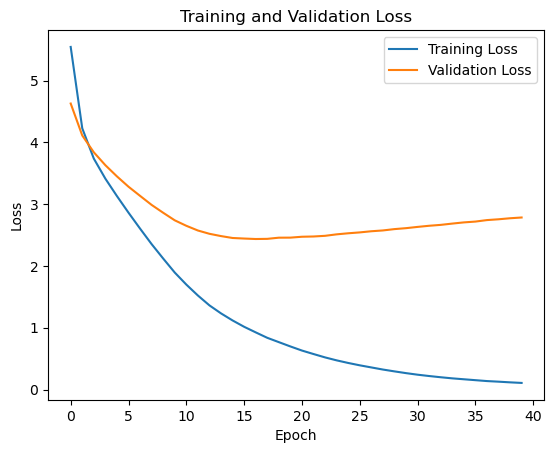

In [96]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the model
model.save('model.h5')

In [ ]:
# Load the trained model
model = load_model('model.h5')

### Evaluating the Model
#### Evaluation is crucial for understanding how well my model performs on unseen data. We using three main stratergies: 

- **BLEU score
- **Perplexity
- **Manual Evaluation


### Inference & Manual Evaluation

During inference (translation of new sentences), the model generates translations one word at a time. This process differs from training, where 
teacher forcing is used. Instead, each predicted word is fed back into the model as input for the next prediction.

We are using a **greedy search strategy** here, always choosing the most probable word at each step. While simple and fast, this approach can sometimes lead to suboptimal translations. 
More advanced techniques like *beam search*, which considers multiple possible sequences, could potentially improve 
translation quality at the cost of increased computation.

In [310]:
def translate_sentence(sentence, model, eng_tokenizer, hin_tokenizer, max_len_eng, max_len_hin):
    # Tokenize and pad the input sentence
    input_seq = eng_tokenizer.texts_to_sequences([sentence])
    input_seq = pad_sequences(input_seq, maxlen=max_len_eng, padding='post')
    
    # Initialize target sequence with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = hin_tokenizer.word_index['start']
    
    # Create reverse word index for Hindi
    reverse_word_index = dict([(idx, word) for word, idx in hin_tokenizer.word_index.items()])
    
    decoded_sentence = []
    
    for _ in range(max_len_hin):
        output = model.predict([input_seq, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        sampled_word = reverse_word_index.get(sampled_token_index, '')
        
        if sampled_word == 'end' or sampled_word == '' or len(decoded_sentence) >= max_len_hin - 1:
            break
        
        decoded_sentence.append(sampled_word)
        
        # Update target sequence
        target_seq = np.zeros((1, len(decoded_sentence) + 1))
        for t, word in enumerate(decoded_sentence):
            target_seq[0, t] = hin_tokenizer.word_index.get(word, 0)  # Use 0 for unknown words
        target_seq[0, len(decoded_sentence)] = sampled_token_index
    
    return ' '.join(decoded_sentence)



In [314]:
# Example usage
english_sentence = X[29]
hindi_translation = translate_sentence(english_sentence, model, eng_tokenizer, hin_tokenizer, max_len_eng, max_len_hin)
print(f"English: {english_sentence}")
print(f"Hindi: {hindi_translation}")

English: start stop event recording
Hindi: घटना रेकोर्डिंग शुरू शुरू करोरोको


In [317]:
xval = X_val
yval = y_val

In [318]:
X_val.shape

(2223, 20)

### Perplexity:

Perplexity is a measure of how well a probability model predicts a sample. In the context of language models, it can be interpreted as the weighted average branching factor of the language. **Lower perplexity indicates better performance.**

- Perplexity is calculated as the **exponential of the cross-entropy loss**. 
-
- It focuses on the **model's confidence in its predictions rather than direct comparison with reference translations** provding a different perspective on model performance compared to BLEU.

In [320]:
def calculate_perplexity(model, input_seq, target_seq, max_len_hin):
    # Shift the target sequence by one for prediction
    y_shifted = np.zeros_like(target_seq)
    y_shifted[:, :-1] = target_seq[:, 1:]
    
    y_pred = model.predict([input_seq, target_seq], verbose=0)
    cross_entropy = sparse_categorical_crossentropy(y_shifted, y_pred)
    perplexity = np.exp(np.mean(cross_entropy))
    return perplexity



In [321]:
perplexity = calculate_perplexity(model, xval, yval, max_len_hin)
print(f"Overall Perplexity: {perplexity}")

Overall Perplexity: 2.3500137329101562


### BLEU (Bilingual Evaluation Understudy) Score:

BLEU is a widely used metric for evaluating the quality of machine-translated text. 

- It compares the model's output to one or more reference translations, measuring the overlap of n-grams (typically up to 4-grams). 
- BLEU scores range from 0 to 1, with **higher scores indicating better translations**.


However, it's important to note that BLEU has limitations. 

- It doesn't account for semantic equivalence and can sometimes assign low scores to good translations that use different but equally valid phrasings. 

Despite these limitations, **BLEU remains a standard metric in machine translation due to its simplicity and correlation with human judgments**.

In [350]:
def translate_tokenized_sequence(input_seq, model, hin_tokenizer, max_len_hin):
    # Initialize target sequence with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = hin_tokenizer.word_index['start']

    # Create reverse word index for Hindi
    reverse_word_index = dict([(idx, word) for word, idx in hin_tokenizer.word_index.items()])

    decoded_sentence = []

    for _ in range(max_len_hin):
        output = model.predict([input_seq, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        sampled_word = reverse_word_index.get(sampled_token_index, '')

        if sampled_word == 'end' or sampled_word == '' or len(decoded_sentence) >= max_len_hin - 1:
            break

        decoded_sentence.append(sampled_word)

        # Update target sequence
        target_seq = np.zeros((1, len(decoded_sentence) + 1))
        for t, word in enumerate(decoded_sentence):
            target_seq[0, t] = hin_tokenizer.word_index.get(word, 0)  # Use 0 for unknown words
        target_seq[0, len(decoded_sentence)] = sampled_token_index

    return decoded_sentence

def calculate_bleu(model, input_seq, target_seq, max_len_eng, max_len_hin, hin_tokenizer):
    smooth_fn = SmoothingFunction().method4
    bleu_scores = []
    for i in range(len(input_seq)):
        decoded_sentence = translate_tokenized_sequence(input_seq[i:i+1], model, hin_tokenizer, max_len_hin)
        reference = target_seq[i].tolist()
        reference_sentence = [hin_tokenizer.index_word[idx] for idx in reference if idx != 0 and idx not in [hin_tokenizer.word_index['start'], hin_tokenizer.word_index['end']]]

        if not reference_sentence:
            continue
        

        bleu_scores.append(sentence_bleu([reference_sentence], decoded_sentence, smoothing_function=smooth_fn))
    return np.mean(bleu_scores)

In [323]:
bleu_score = calculate_bleu(model, xval, yval, max_len_eng, max_len_hin, hin_tokenizer)
print('/n')
print(f"Overall BLEU Score: {bleu_score}")


Decoded: हाल में खेल के साथ फाइल
Reference: हाल में खेले खेल के नाम
/n
Overall BLEU Score: 0.31237541294178106


In [351]:
perplexities = []
token_size = []
bleu_score = []
for i in range(len(xval)):
    p = calculate_perplexity(model, xval[i:i+1],yval[i:i+1], max_len_hin)
    perplexities.append(p)
    token_size.append(np.count_nonzero(xval[i]))
    b = calculate_bleu(model, xval[i:i+1], yval[i:i+1], max_len_eng, max_len_hin, hin_tokenizer)
    bleu_score.append(b)

In [325]:
# Remove NaN values from bleu_score and corresponding values from other lists
valid_indices = [i for i, b in enumerate(bleu_score) if not np.isnan(b)]
perplexities = [perplexities[i] for i in valid_indices]
token_size = [token_size[i] for i in valid_indices]
bleu_score = [bleu_score[i] for i in valid_indices]

In [326]:
# Convert lists to DataFrame for easier manipulation
eval_data = pd.DataFrame({
    'token_size': token_size,
    'perplexities': perplexities,
    'bleu_score': bleu_score
})


In [327]:
eval_data.head()

,token_size,perplexities,bleu_score
0,3,1.000740,0.137429
1,4,1.000566,0.211780
2,2,1.000549,0.221389
3,16,9384.836914,0.014632
4,6,1.402962,0.295584


In [336]:
# Define the bins and labels
bins = [0, 5, 10, 15, 20]
labels = ['1-5', '6-10', '11-15', '16-20']

# Create a new column for the bins
eval_data['token_size_bin'] = pd.cut(eval_data['token_size'], bins=bins, labels=labels)

# Group by the new bins and calculate mean perplexity, BLEU score, and count
grouped_data = eval_data.groupby('token_size_bin').agg({
    'perplexities': 'mean',
    'bleu_score': 'mean',
    'token_size': 'count'
}).rename(columns={'token_size': 'count'}).reset_index()


In [337]:
grouped_data.head(20)

,token_size_bin,perplexities,bleu_score,count
0,1-5,1.431235,0.359508,1629
1,6-10,148.393509,0.233733,301
2,11-15,4049.943848,0.100812,177
3,16-20,19267.025391,0.042362,58


### Performance Degradation with Sequence Length

As the length of input sequences increases, the performance of my seq2seq LSTM model tends to degrade. This is a common issue with sequence-to-sequence models and stems from the **difficulty in maintaining long-term dependencies over extended sequences**.

The root cause of this problem lies in the **fixed-length context vector** used to pass information from the encoder to the decoder. 
- As sequences get longer, it becomes increasingly challenging to compress all relevant information into this fixed-length vector. This can lead to loss of important details, especially for words at the beginning of long sequences.

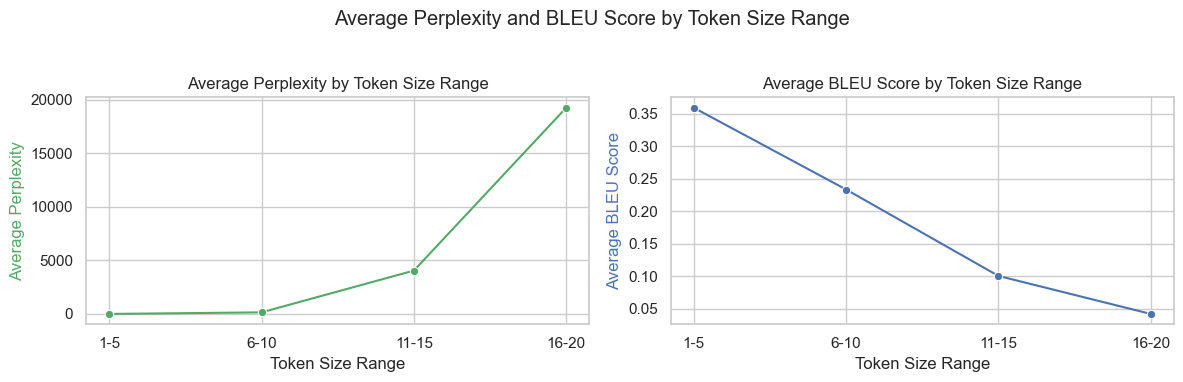

In [341]:
# Plotting with seaborn
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting average perplexity
sns.lineplot(data=grouped_data, x='token_size_bin', y='perplexities', ax=ax1, marker='o', color='g')
ax1.set_ylabel('Average Perplexity', color='g')
ax1.set_xlabel('Token Size Range')
ax1.set_title('Average Perplexity by Token Size Range')

# Plotting average BLEU score
sns.lineplot(data=grouped_data, x='token_size_bin', y='bleu_score', ax=ax2, marker='o', color='b')
ax2.set_ylabel('Average BLEU Score', color='b')
ax2.set_xlabel('Token Size Range')
ax2.set_title('Average BLEU Score by Token Size Range')

plt.suptitle('Average Perplexity and BLEU Score by Token Size Range')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Here we can see this phenomenon as we break down the Bleu score & Perplexity score for ~2300 validation set based on number of input words/tokens
- The Perplexity score increases as sentences get longer
- The Bleu score decreses as sentences get longer

Both implying the **vanishing gradient problem** where the information from longer sentences get lost when getting encoded in the context vector. 

### Attention Mechanisms and Transformers

To address the limitations of traditional seq2seq models, **attention mechanisms** were introduced. 

- Attention allows the model to focus on different parts of the input sequence when generating each word of the output, rather than relying solely on a fixed-length context vector.

Building upon the success of attention, transformer models have become the state-of-the-art in many sequence-to-sequence tasks, including machine translation. 

**Transformers rely entirely on attention mechanisms**, dispensing with recurrence and convolutions entirely. This allows for more parallelization during training and enables the model to capture long-range dependencies more effectively.


### State of the art models for Machine Translation
Some of the most advanced translation models today, such as **Google's T5 (Text-to-Text Transfer Transformer)** and **OpenAI's GPT-3**, are based on the transformer architecture. These models have achieved unprecedented performance on a wide range of natural language tasks, including translation.

While our current implementation using seq2seq LSTM provides a solid foundation and helps in understanding the core concepts of neural machine translation, transitioning to a transformer-based model would likely yield significant improvements in translation quality, especially for longer sequences and more complex language pairs.